Adding Data to Colab database

In [2]:
# This data is taken from github repository.
!git clone https://github.com/ShGanesh/Age_Gender_Detection.git
%cd Age_Gender_Detection

print("\n\nData Taken:")
!ls

Cloning into 'Age_Gender_Detection'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.
/content/Age_Gender_Detection/Age_Gender_Detection


Data Taken:
genderage.ipynb  image2.jpg  LICENSE	video.mp4.avi
image1.jpg	 image.jpg   README.md


In [4]:
# Data for trained weights taken from Google Drive.
!gdown https://drive.google.com/uc?id=1-P7b_PpNpz6wtxI5ajfRGALT4rY_AJ7q
!unzip modelNweight.zip

Downloading...
From: https://drive.google.com/uc?id=1-P7b_PpNpz6wtxI5ajfRGALT4rY_AJ7q
To: /content/Age_Gender_Detection/Age_Gender_Detection/modelNweight.zip
86.2MB [00:00, 208MB/s]
Archive:  modelNweight.zip
   creating: modelNweight/
  inflating: modelNweight/age_deploy.prototxt  
  inflating: modelNweight/age_net.caffemodel  
  inflating: modelNweight/gender_deploy.prototxt  
  inflating: modelNweight/gender_net.caffemodel  
  inflating: modelNweight/opencv_face_detector.pbtxt  
  inflating: modelNweight/opencv_face_detector_uint8.pb  
genderage.ipynb  image2.jpg  LICENSE	   modelNweight.zip  video.mp4.avi
image1.jpg	 image.jpg   modelNweight  README.md


Framing Output, applying network to produce pre-output

In [6]:
import cv2 as cv
import math
import time
from google.colab.patches import cv2_imshow
from tkinter import Frame
def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"

ageProto = "modelNweight/age_deploy.prototxt"
ageModel = "modelNweight/age_net.caffemodel"

genderProto = "modelNweight/gender_deploy.prototxt"
genderModel = "modelNweight/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20

def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace

Testing model on images

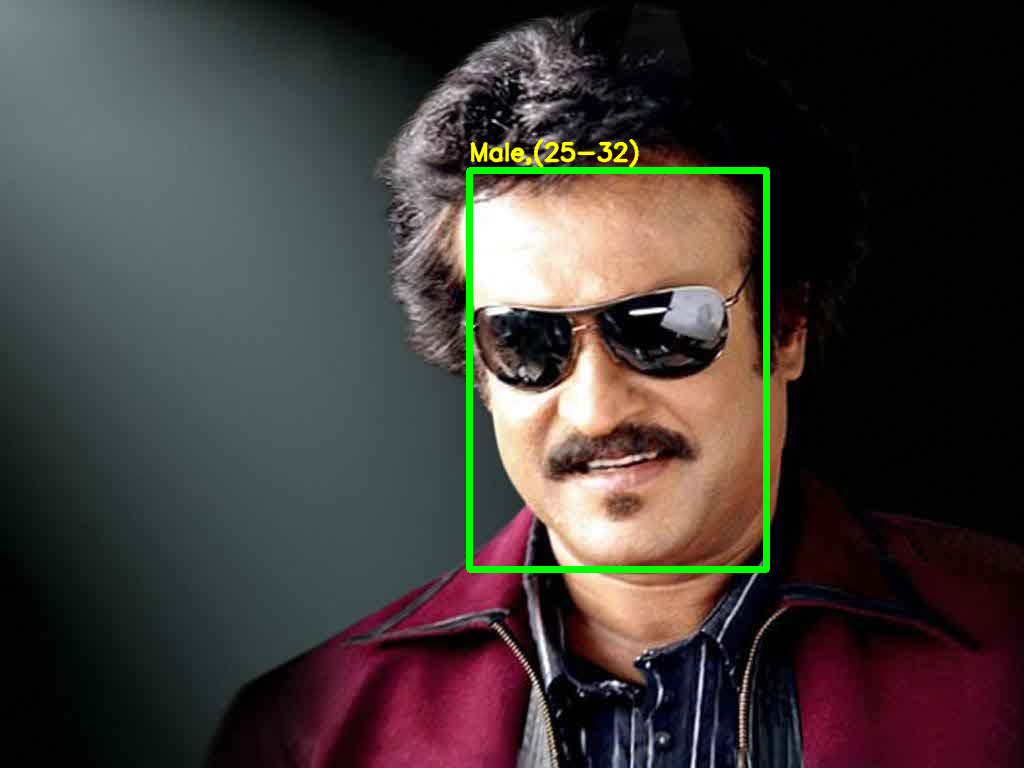

In [14]:
input = cv.imread("image.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

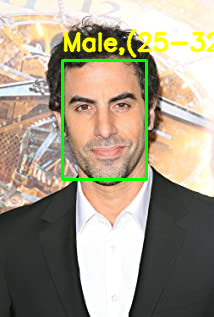

In [16]:
input = cv.imread("image2.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

Calling, and processing video.  
Creating output video with real-time gender and age prediction.

In [15]:
import cv2
cap = cv2.VideoCapture('video.mp4.avi')
ret, frame = cap.read()
frame_height, frame_width,_  = frame.shape
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = age_gender_detector(frame)
  out.write(output)
out.release()
print("Done processing video")

Processing Video...
Done processing video


Playing output video.   
This part of the code is dedicated towards playing output video in Google Colab itself so that viewers do not have to download the output.

In [ ]:
!ffmpeg -i output.avi output.mp4    # Conversion of .avi file to .mp4
 
from IPython.display import HTML
from base64 import b64encode
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib